In [1]:
%pylab inline
import numpy as np
from parameter import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
fontsize   = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv =  np.cos(t)*ifft((1j*k*fft(u))) + b*u*ifft(1j*k*fft(u)) + c*ifft(-k**2*fft(u))
    return real(deriv)

In [3]:
n = 256
m = 256

# Set up grid
x = np.linspace(-8,8,n+1)[:-1];    dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve the rhs for data 
params = (k, -1,-2,0.3)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T
#Understanding and preparing the data

u_x_true = np.cos(t)
uu_x_true = -2*np.ones(m)
u_xx_true = 0.3*np.ones(m)

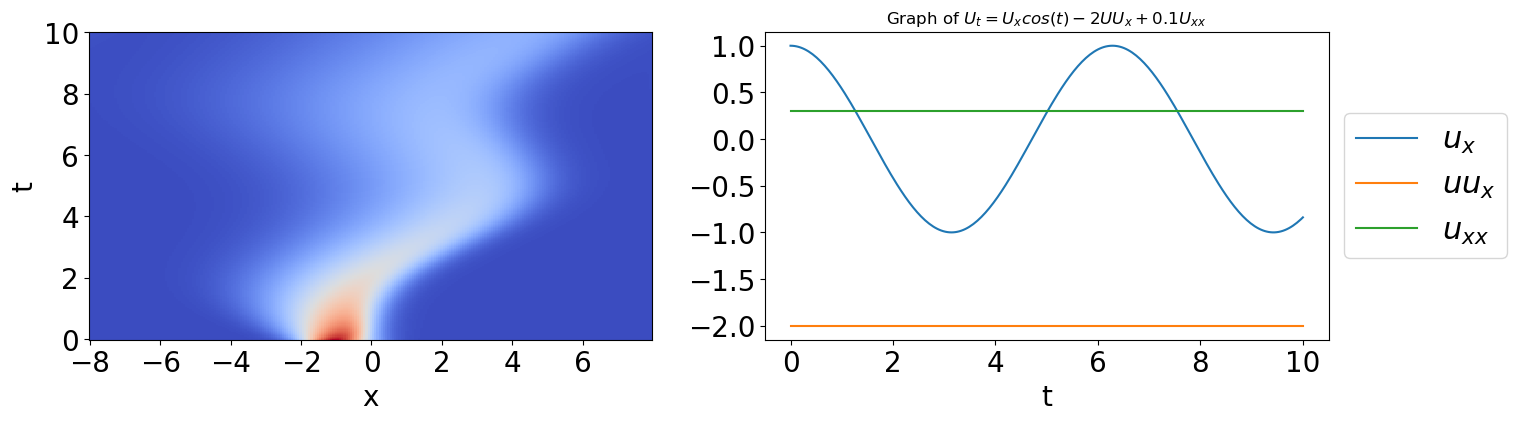

In [5]:
fig=figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
#xlim([x[0],x[-1]]) 

subplot(1,2,2)
#plot(t,u_true, label=r'$u$')
plot(t,u_x_true, label=r'$u_{x}$')
plot(t, uu_x_true, label=r'$uu_{x}$')
plot(t, u_xx_true, label=r'$u_{xx}$')
title("Graph of $U_t = U_xcos(t) - 2UU_x + 0.1U_{xx}$")


xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('t', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [6]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=2, P=1, time_diff = 'FD', space_diff = 'FD')

#Feature Engineering 

In [7]:
Theta_grouped = [real(Theta[j*n:(j+1)*n,:]) for j in range(m)]
Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]

C:\Users\brvhh\OneDrive\Documents\Python Scripts\ProtoCodes\parameter.py:574: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


MSE:  4.6869607024857875e-07


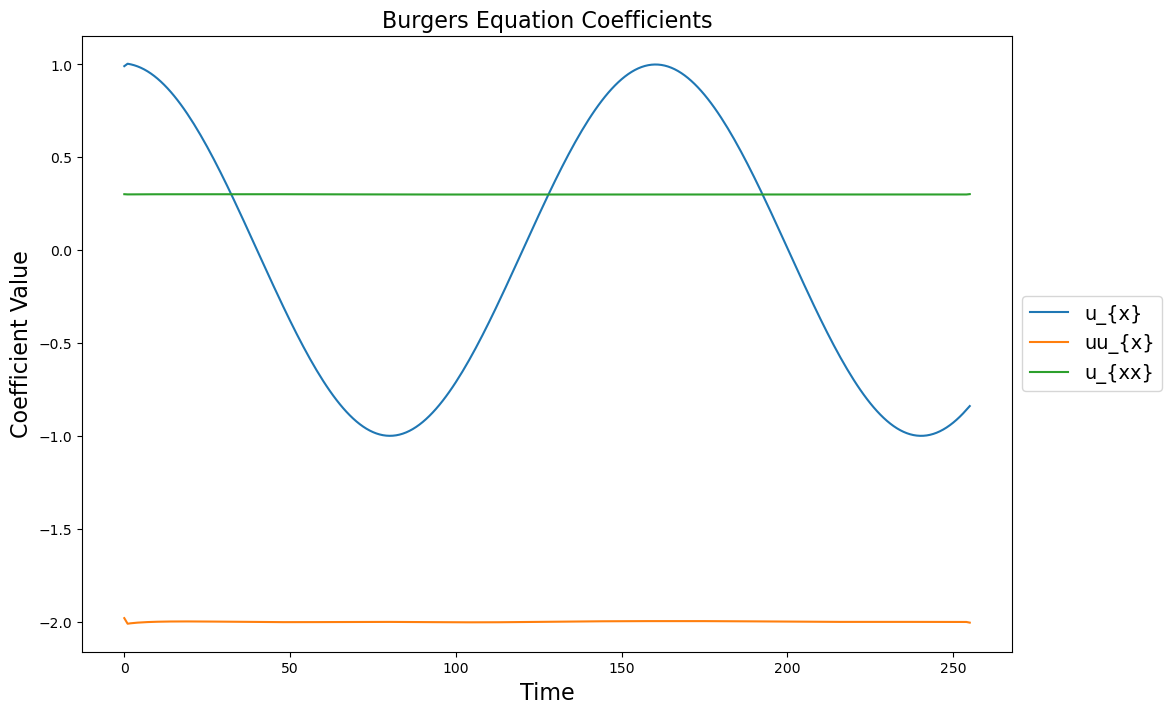

In [8]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)] #Losses is used to check the 

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(xi[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

i_u = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u'][0]
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
i_uu_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'uu_{x}'][0]
i_u_xx = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{xx}'][0]
xi_true = np.zeros(xi.shape)
xi_true[i_uu_x] = uu_x_true
xi_true[i_u_xx] = u_xx_true
xi_true[i_u_x] = u_x_true
mse_clean_sgtr = Norm(xi-xi_true)**2/(m*16)

print('MSE: ', mse_clean_sgtr)

In [9]:
#Create a new set of data in relation to U
un = u + 0.0002*std(u)*np.random.randn(n,m)

In [10]:
wx = 10 
wt = 10 

Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=2, P=1, time_diff = 'FD',
                                       deg_x = 4, deg_t = None, 
                                       width_x = wx, width_t = wt )
n2 = n - 2*wx
m2 = m - 2*wt

In [11]:
Thetan_grouped = [real(Thetan[j*n2:(j+1)*n2,:]) for j in range(m2)]
Utn_grouped = [real(Utn[j*n2:(j+1)*n2]) for j in range(m2)]

MSE:  0.004767962954636629


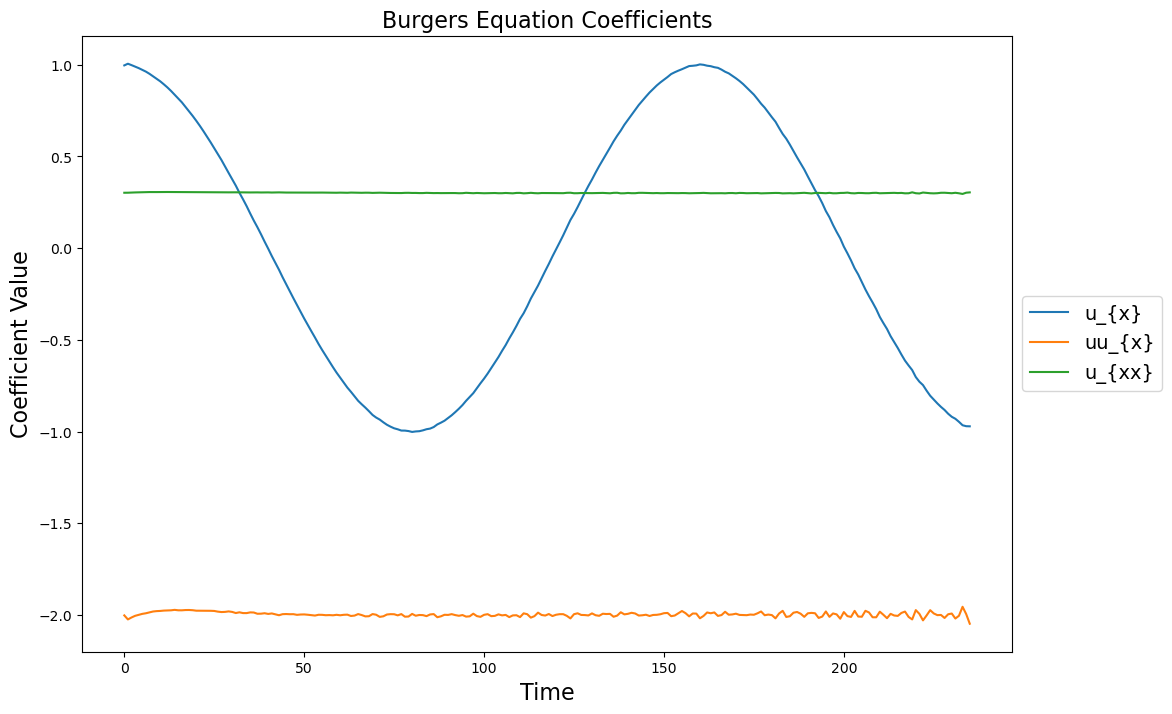

In [12]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_n-xi_true[:,wt:-wt])**2/(m2*16)
print('MSE: ', mse_noise_sgtr)

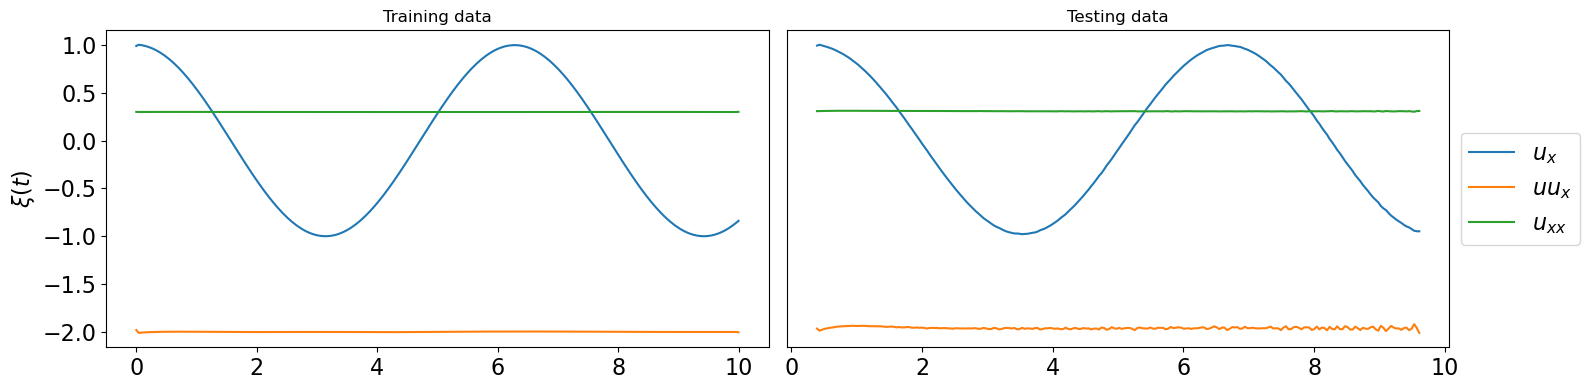

In [13]:
figure(figsize = (16,4))
label_fs = 16

subplot(1,2,1)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(t,xi[j,:], label = rhs_des[j])

ylabel(r'$\xi(t)$', fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)
title("Training data")

subplot(1,2,2)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(t[wt:-wt],xi_n[j,:], label = '$'+rhs_des[j]+'$')
        
xticks(fontsize = 16)
yticks([], fontsize = 16) 
title("Testing data")

legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 16)

tight_layout()